# Experimenting with xcube

## Imports & Constants

In [2]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers

import time
import geojson
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm

request_collector = Observers.request_dumper()
end_dates = ['2018-01-31', '2018-02-28', '2018-03-31']
ic = ['id', 'n_months'] # index columns

## Building the GeoDataFrame

In [113]:
# Read GeoJSON
gdf = gpd.read_file('../geodata/municipalities_sample_bbox.geojson')

# Store geometry representations
gdf['bbox'] = gdf.bounds.apply(tuple, axis=1)
gdf['wkt'] = gdf.apply(lambda f: f.geometry.wkt, axis=1)
gdf['geojson'] = gdf.apply(lambda f: f.geometry.__geo_interface__, axis=1)

# Calculate areas in m²
area_25832 = gdf.cx[:12.0,:].to_crs('EPSG:25832').area # ETRS89 / UTM Zone 32N for Vbg and Tyrol
area_25833 = gdf.cx[12.0:, :].to_crs('EPSG:25833').area   # ETRS89 / UTM Zone 33N for rest of Austria
gdf['area'] = pd.concat([area_25832,area_25833])

## Functions

In [6]:
def write_cube(feature, time_range, n_months):
    '''
    This will write a zarr file using the specified parameters.
    
    # Input
    
    tuple(*attributes) feature
    list[date_string start, date_string end] time_range
    
    
    # Example: 
    
    write_cube(
        Pandas(
            Index=0,
            id='10604',
            name='Loipersbach im Burgenland',
            bbox=(16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863),
            wkt='MULTIPOLYGON (((16.47614442528707 47.71419149821737,...)))
        ),
        ['2018-01-01', '2018-01-31']
    )
    '''
    
    bands = ['B04']
    config = CubeConfig(
        dataset_name="S2L2A",
        band_names=bands,
        geometry=feature.bbox,
        #tile_size=[1024, 12],
        crs='http://www.opengis.net/def/crs/EPSG/0/4326',
        spatial_res=0.000134,
        time_range=time_range,
        time_period='2W'
    )
    open_cube(config, observer=request_collector).to_zarr(f"{feature.Index}_{n_months}_{feature.name}_{'_'.join(time_range)}_{time.time()}.zarr")

## xcube in action 🔢

In [51]:
!rm -r *.zarr
times = []

for i in range(len(end_dates)):
    n_months = i+1
    for feat in gdf.drop('geometry', axis=1).itertuples():
        tr = %timeit -n 1 -r 3 -o write_cube(feat, ['2018-01-01', end_dates[i]], n_months) # TimeitResult
        times.append({ic[0]: feat.Index, ic[1]: n_months, **vars(tr), 'mean': tr.average, 'stdev': tr.stdev})

disk_usage = !du *.zarr -s | sort -h

Received chunk (0, 0, 0) for band B04: took 863.45 ms
Received chunk (1, 0, 0) for band B04: took 2406.81 ms
Received chunk (2, 0, 0) for band B04: took 1611.43 ms
Received chunk (1, 0, 0) for band B04: took 751.80 ms
Received chunk (2, 0, 0) for band B04: took 789.28 ms
Received chunk (0, 0, 0) for band B04: took 1765.92 ms
Received chunk (0, 0, 0) for band B04: took 297.66 ms
Received chunk (1, 0, 0) for band B04: took 704.66 ms
Received chunk (2, 0, 0) for band B04: took 501.57 ms
2.5 s ± 683 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Received chunk (1, 0, 0) for band B04: took 809.56 ms
Received chunk (0, 0, 0) for band B04: took 861.67 ms
Received chunk (2, 0, 0) for band B04: took 893.60 ms
Received chunk (0, 0, 0) for band B04: took 595.36 ms
Received chunk (1, 0, 0) for band B04: took 1358.02 ms
Received chunk (2, 0, 0) for band B04: took 825.93 ms
Received chunk (1, 0, 0) for band B04: took 363.21 ms
Received chunk (0, 0, 0) for band B04: took 1047.79 ms
Received ch

## Munging Results

In [177]:
# Build disk usage dataframe
dudf = pd.DataFrame([du.split('\t') for du in disk_usage], columns=["KB", "filename"])
dudf['KB'] = pd.to_numeric(dudf['KB'])
dudf[ic[0]], dudf[ic[1]] = list(zip(*dudf['filename'].apply(lambda fn: fn.split('_')[:2])))

# Make sure that orginal index is used
dudf = dudf.drop_duplicates(subset=ic)
dudf[ic] = dudf[ic].apply(pd.to_numeric)
dudf = dudf.set_index(ic)

assert len(dudf) == len(gdf)*len(end_dates), 'DataFrame sizes do not match'
dudf

KB                                           filename
id n_months                                                         
3  1          728  3_1_Bludesch_2018-01-01_2018-01-31_1583403981....
0  1          940  0_1_Loipersbach im Burgenland_2018-01-01_2018-...
3  2         1108  3_2_Bludesch_2018-01-01_2018-02-28_1583404019....
   3         1512  3_3_Bludesch_2018-01-01_2018-03-31_1583404064....
0  2         1540  0_2_Loipersbach im Burgenland_2018-01-01_2018-...
1  1         1876  1_1_Weißenkirchen in der Wachau_2018-01-01_201...
0  3         2036  0_3_Loipersbach im Burgenland_2018-01-01_2018-...
4  1         2312  4_1_Alberschwende_2018-01-01_2018-01-31_158340...
1  2         3216  1_2_Weißenkirchen in der Wachau_2018-01-01_201...
4  2         3856  4_2_Alberschwende_2018-01-01_2018-02-28_158340...
1  3         4252  1_3_Weißenkirchen in der Wachau_2018-01-01_201...
2  1         4444  2_1_Sankt Stefan ob Stainz_2018-01-01_2018-01-...
4  3         5176  4_3_Alberschwende_2018-01-01_2018-03-31_158340...
2  2         7272  2_2_Sankt Stefan ob Stainz_2018-01-01_2018-02-...
   3         9688  2_3_Sankt Stefan ob Stainz_2018-01-01_2018-03-...

In [149]:
# Build Time Dataframe
tdf = pd.DataFrame(times).set_index(ic)
assert len(tdf) == len(gdf)*len(end_dates), 'DataFrame sizes do not match'
tdf.loc[(slice(None),3),:]

,,_precision,all_runs,best,compile_time,loops,mean,repeat,stdev,timings,worst
id,n_months,,,,,,,,,,
0,3,3,"[2.3642291920259595, 2.755173804005608, 1.9592...",1.959297,0.000084,1,2.359567,3,0.324932,"[2.3642291920259595, 2.755173804005608, 1.9592...",2.755174
1,3,3,"[2.996488436125219, 3.3163899208884686, 2.6824...",2.682475,0.000071,1,2.998451,3,0.258798,"[2.996488436125219, 3.3163899208884686, 2.6824...",3.316390
2,3,3,"[4.68667290895246, 4.745916405925527, 4.796447...",4.686673,0.000068,1,4.743012,3,0.044862,"[4.68667290895246, 4.745916405925527, 4.796447...",4.796447
3,3,3,"[4.450747269205749, 2.6661773601081222, 3.5290...",2.666177,0.000089,1,3.548651,3,0.728680,"[4.450747269205749, 2.6661773601081222, 3.5290...",4.450747
4,3,3,"[3.8592222419101745, 3.5245375570375472, 3.734...",3.524538,0.000073,1,3.706235,3,0.138134,"[3.8592222419101745, 3.5245375570375472, 3.734...",3.859222


## Predictions

In [185]:
preddf = pd.merge(dudf['KB'], gdf['area'],how="left", left_on=ic[0], right_index=True)
preddf = preddf.loc[(slice(None),1), :]

Y = np.asarray(preddf['KB'])
X = sm.add_constant(np.asarray(preddf['area']))
model = sm.OLS(Y,X).fit()
model.predict(X)

array([ 681.53085239,  923.34368828, 1978.97308555, 2302.93728872,
       4413.21508505])

## Plots

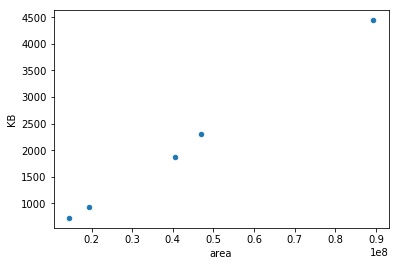

In [186]:
preddf.plot(x='area', y='KB', kind='scatter')